In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import scipy.stats as st

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

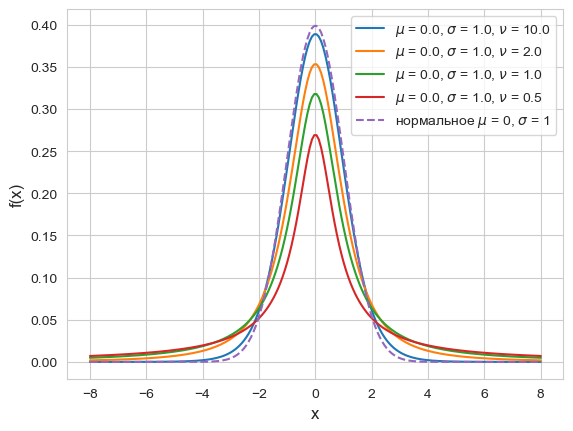

In [118]:
x = np.linspace(-8, 8, 200)
mus = [0., 0., 0., 0.]
sigmas = [1., 1., 1., 1.]
dfs = [10., 2., 1., 0.5]
for mu, sigma, df in zip(mus, sigmas, dfs):
    pdf = st.t.pdf(x, df, loc=mu, scale=sigma)
    plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}, $\nu$ = {}'.format(mu, sigma, df))

pdf = st.norm.pdf(x, 0, 1)
plt.plot(x, pdf, label=r'нормальное $\mu$ = 0, $\sigma$ = 1', linestyle='dashed')
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

### Распределение Коши

не имеет математического ожидания и дисперсии

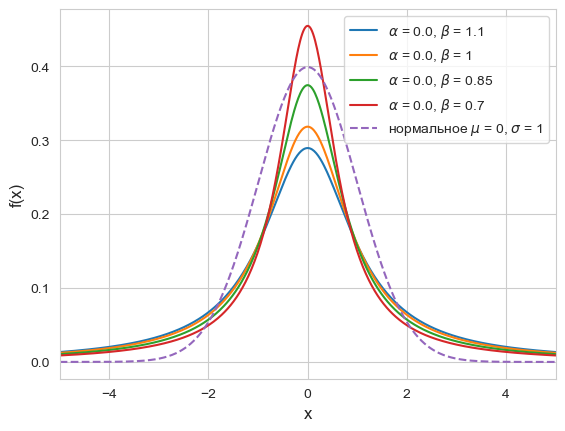

In [122]:
x = np.linspace(-5, 5, 500)
alphas = [0., 0., 0., 0.]
betas = [ 1.1, 1, 0.85, 0.7]
for a, b in zip(alphas, betas):
    pdf = st.cauchy.pdf(x, loc=a, scale=b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))

pdf = st.norm.pdf(x, 0, 1)
plt.plot(x, pdf, label=r'нормальное $\mu$ = 0, $\sigma$ = 1', linestyle='dashed')

plt.xlim(-5, 5)
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

## Иерархическая линейная регрессия

Применим концепцию иерархических моделей к линейной регрессии. Такой подход позволяет моделям выполнять статистические выводы на уровне групп, а оценки вычислять на более высоком уровне. Как уже было сказано ранее, это осуществляется с помощью введения априорных гиперраспределений.

Создадим восемь взаимосвязанных групп данных, включая одну группу с единственной точкой данных:

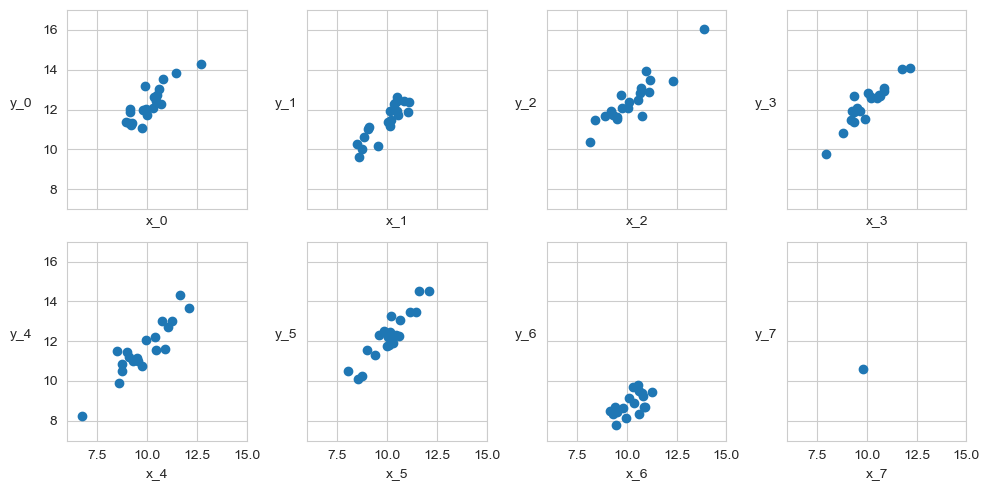

In [125]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(42)



alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

Центрируем данные для облегчения работы сэмплера и выполним подгонку  <b>неиерархической</b> модели.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β, σ, μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


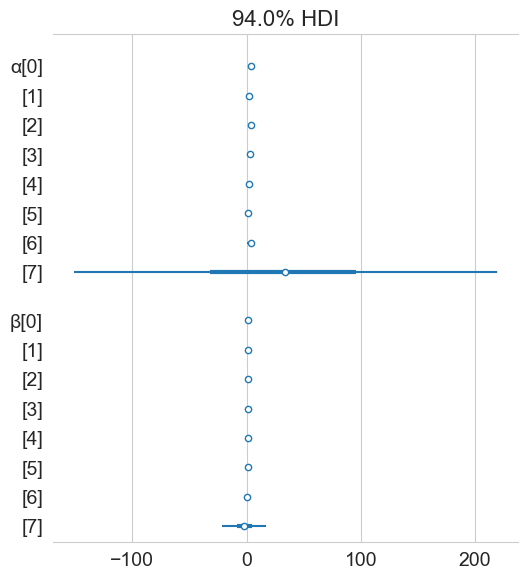

In [128]:
x_centered = x_m - x_m.mean()

with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10, shape=M)
    β = pm.Normal('β', mu=0, sigma=10, shape=M)
    ε = pm.HalfStudentT('σ', 5)
    ν = pm.Exponential('μ', 1/30)

    y_pred = pm.StudentT('y_pred', 
                         mu=α_tmp[idx] + β[idx] * x_centered,
                         sigma=ε, 
                         nu=ν, 
                         observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())

    trace_up = pm.sample(1000, chains = 4, cores = 4)
az.plot_forest(trace_up, var_names=['α', 'β'], combined=True);

In [129]:
trace_up

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Очевидно, что оценки параметров $\alpha_7$ и $\beta_7$ находятся в чрезвычайно широком интервале по сравнению с остальными параметрами 
$\alpha_{0-6}$ и $\beta_{0-6}$.

Это происходит, так как необходимы, по меньшей мере, две точки, иначе параметры $\alpha$  и $\beta$ становятся неограниченными. Это действительно так, если только не будет предоставлена некоторая дополнительная информация, например с использованием априорных распределений. Назначение строго определенного априорного распределения
для $\alpha$ может привести к генерации четко определенного набора линий даже для одной точки данных. 

Другой способ передачи информации – определение иерархических моделей, поскольку они позволяют совместно использовать информацию нескольким группам, редуцируя правдоподобные значения оцениваемых параметров. Это становится весьма полезным в тех случаях, когда имеются группы с разреженными (разбросанными) данными. В рассматриваемом примере разреженность данных была доведена до предела - одна из групп содержала единственную точку данных.

Теперь выполним реализацию иерархической модели, которая представляет собой ту же обычную модель линейной регрессии, но с априорными гиперраспределениями, которые можно наглядно изобразить на следующей диаграмме:
 ![](pict/02-IerLinModel.png)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ_tmp, α_σ_tmp, β_μ, β_σ, α_tmp, β, ε, ν]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.


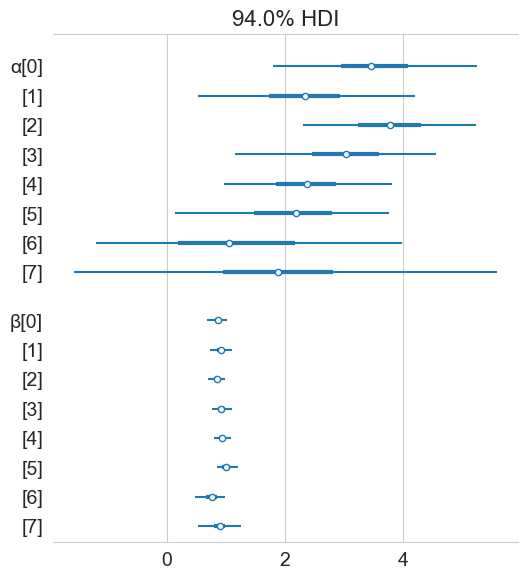

In [146]:
with pm.Model() as hierarchical_model:
    # априорные гипер-распределения
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=10)
    β_μ = pm.Normal('β_μ', mu=0, sigma=1)
    β_σ = pm.HalfNormal('β_σ', sigma=1)

    # априорные распеределения
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=M)
    ε = pm.HalfCauchy('ε', 5)   
    ν = pm.Exponential('ν', 1/30)
    
    # апосториорное распределение
    y_pred = pm.StudentT('y_pred', 
                         mu=α_tmp[idx] + β[idx] * x_centered,
                         sigma=ε, 
                         nu=ν, observed=y_m)
    
    # обратное перемасштабирование
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    # трассировка
    trace_hm = pm.sample(1000, chains = 4, cores = 4, target_accept=.95) #target_accept=.8

az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);

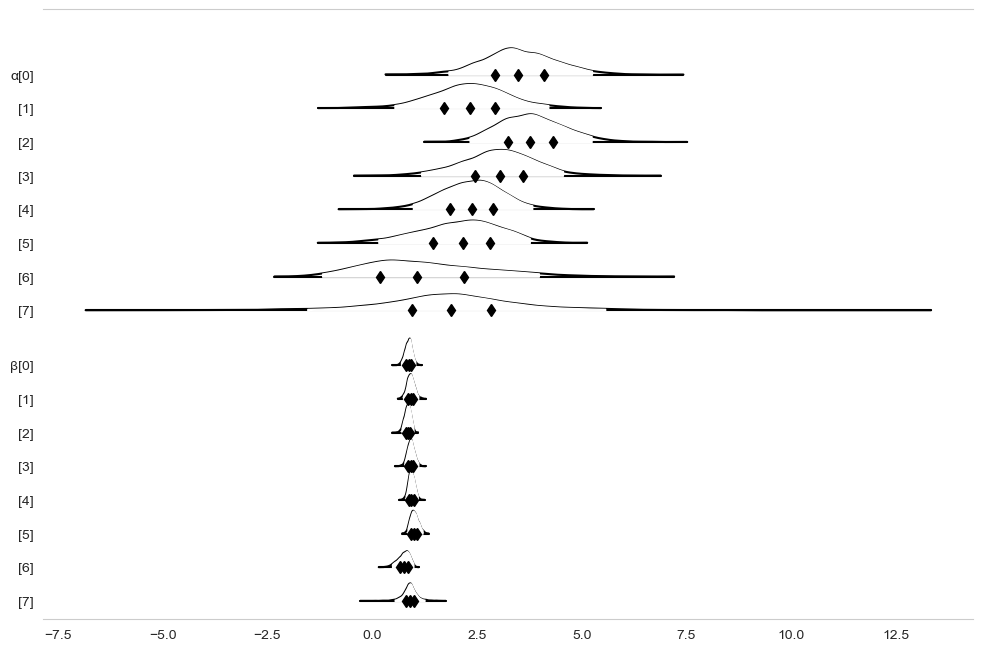

In [148]:
az.plot_forest(trace_hm, var_names=['α', 'β'],kind ='ridgeplot', 
               combined=True, 
               ridgeplot_truncate=False,
               ridgeplot_quantiles=[.25, .5, .75],
               ridgeplot_overlap=0.7,
               colors='white');

In [150]:
trace_hm.posterior.stack(samples={"chain", "draw"})['α'].sel({'α_dim_0':1}).mean().item()

2.317068273331664

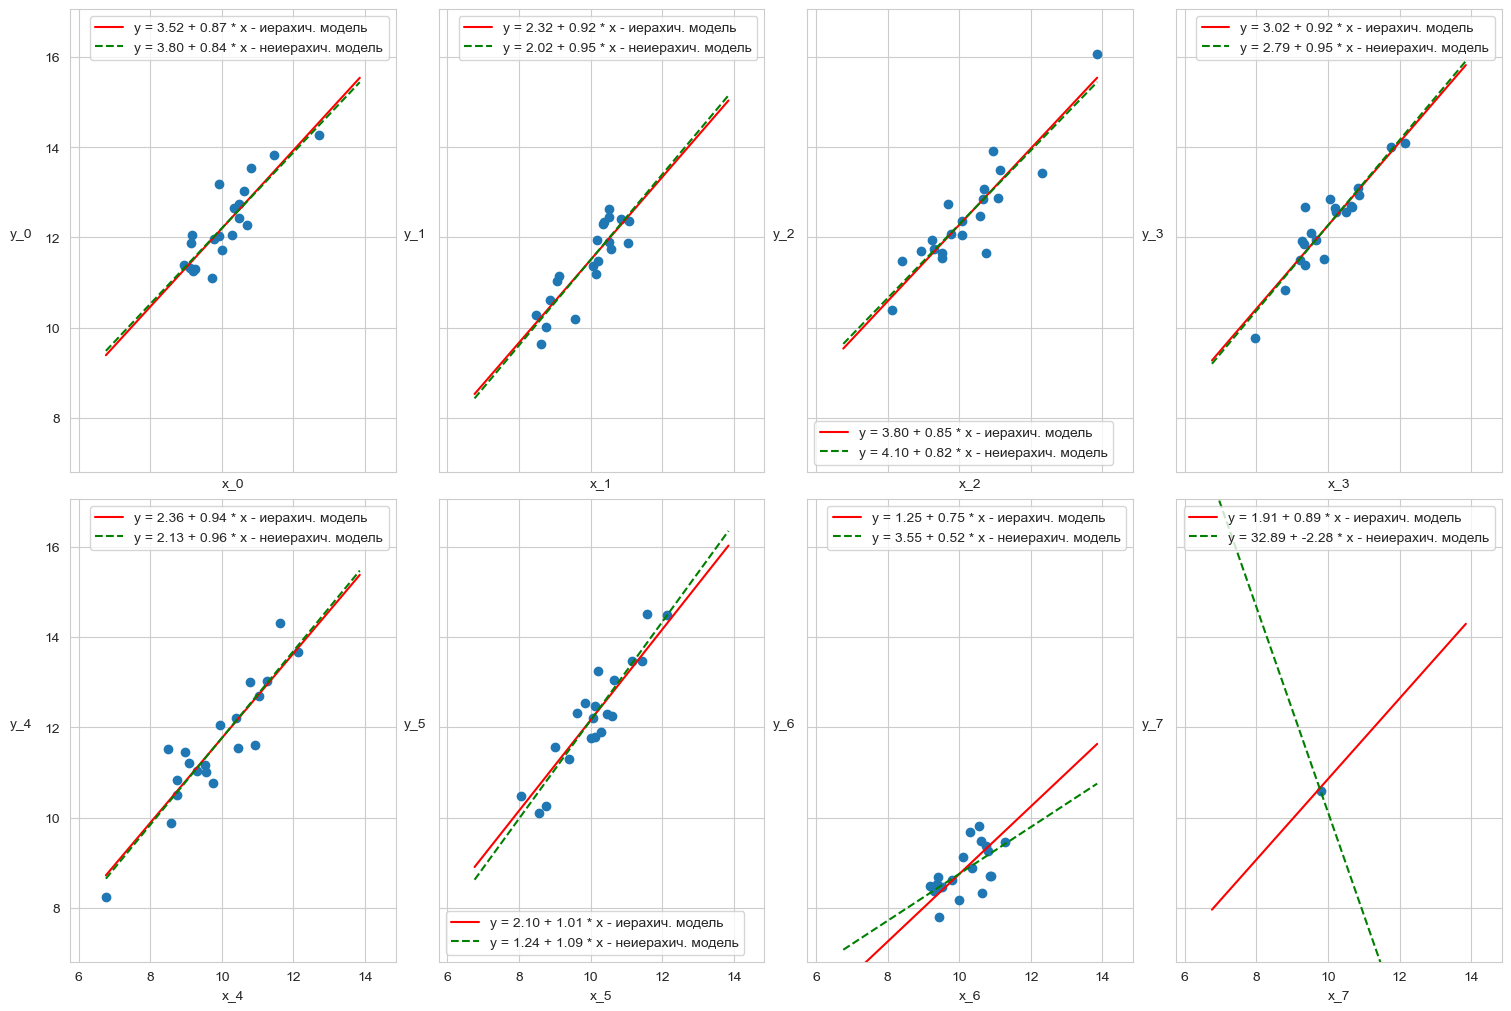

In [152]:
_, ax = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True,
                     constrained_layout=True)

trace_hmm = trace_hm.posterior.stack(samples={"chain", "draw"})
trace_upp = trace_up.posterior.stack(samples={"chain", "draw"})


ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)

for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hmm['α'].sel({'α_dim_0':i}).mean().item()
    beta_m  = trace_hmm['β'].sel({'β_dim_0':i}).mean().item()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='r',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x'+' - иерахич. модель')

    alpha_o = trace_upp['α'].sel({'α_dim_0':i}).mean().item()
    beta_o = trace_upp['β'].sel({'β_dim_0':i}).mean().item()
    ax[i].plot(x_range, alpha_o + beta_o * x_range, 'g--',
               label=f'y = {alpha_o:.2f} + {beta_o:.2f} * x'+' - неиерахич. модель')
    
    ax[i].legend()
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
    

Повторим еще раз, это является прямым следствием применения структуры иерархической модели, каждая линия получает информацию от линий других групп, таким образом, в действительности подгонка линии выполняется не по единственной точке. 

## Полиномиальная регрессия

Приведем построение полиномиальной регрессии, только в качестве примера. Позднее мы обсудим линейные и полиномиальные регрессии в теме сравнение "моделей"

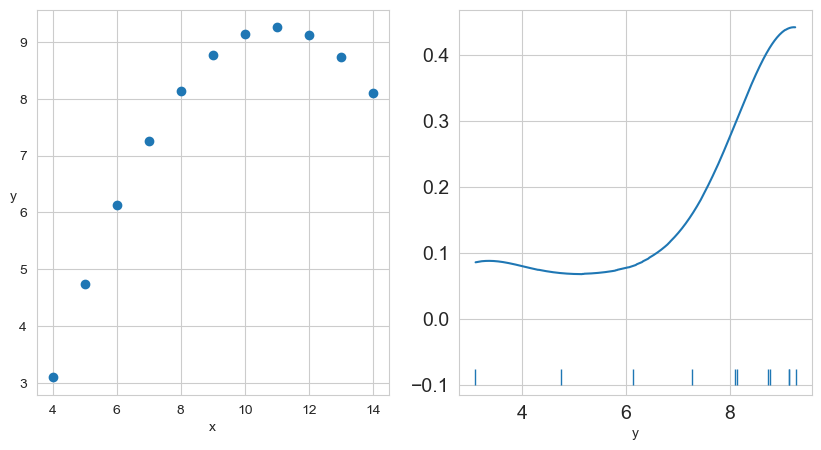

In [154]:
df = sns.load_dataset("anscombe")
x = df[df.dataset=="II"].x.values
y = df[df.dataset=="II"].y.values

_, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(x, y, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)

az.plot_kde(y, ax=ax[1], rug=True)
ax[1].set_xlabel('y');

In [156]:
with pm.Model() as model_poly:
    α =  pm.Normal('α',  mu=0, sigma=10)
    β1 = pm.Normal('β1', mu=0, sigma=10)
    β2 = pm.Normal('β2', mu=0, sigma=10)
    ε =  pm.Uniform('ε', lower=0, upper=10)    
    mu = α + β1 * x + β2 * x**2
    y_pred = pm.Normal('y_pred', mu=mu, sigma=ε, observed=y)
    
    trace_poly = pm.sample(1000, chains=4, cores = 4, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, ε]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


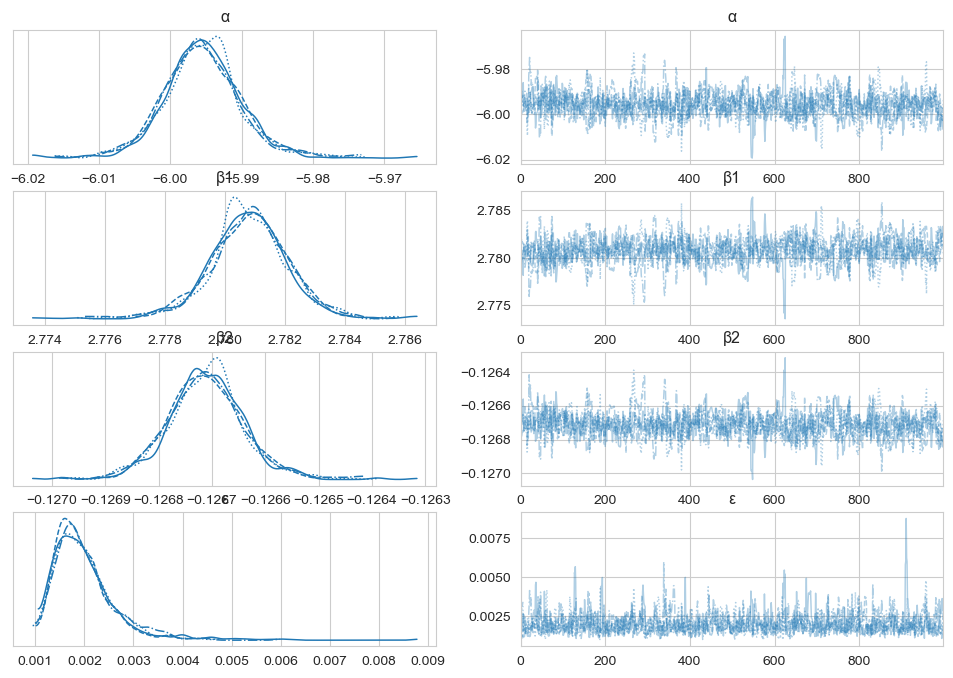

In [157]:
az.plot_trace(trace_poly);

In [158]:
az.summary(trace_poly)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-5.996,0.005,-6.006,-5.985,0.0,0.0,705.0,722.0,1.0
β1,2.781,0.001,2.778,2.783,0.0,0.0,666.0,627.0,1.0
β2,-0.127,0.000,-0.127,-0.127,0.0,0.0,670.0,652.0,1.0
ε,0.002,0.001,0.001,0.003,0.0,0.0,932.0,1218.0,1.0


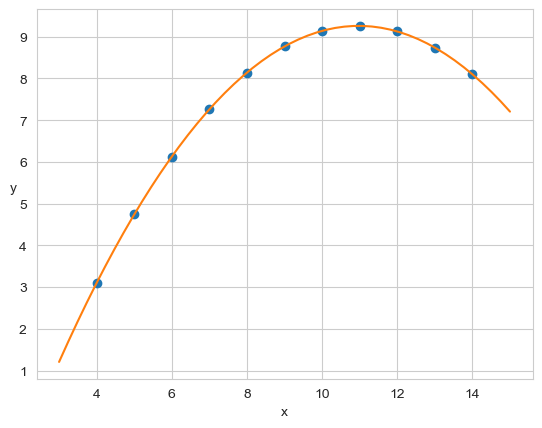

In [12]:
line_poly = trace_poly.posterior.stack(samples={"chain", "draw"})

x_p = np.linspace(3, 15)
y_p =   line_poly['α'].mean().item() + \
        line_poly['β1'].mean().item() * x_p + \
        line_poly['β2'].mean().item() * x_p**2

plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1');